## Goal

Build a simple chain within our graph that uses 4 concepts/tools
- Use chat messages in the graph
- Invoking chat models within graph
- Binding tools to out LLM
- Executing tool calls in our graph

In [37]:
# general imports
import sys
import os, getpass
from openai import OpenAI
from utils import *
from IPython.display import Image
from pprint import pprint

# Import langgraph modules to create and visualize the graph
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage 
from typing_extensions import TypedDict
from typing import Literal
from pydantic import BaseModel, Field

# Install the missing package
# %pip install langchain_anthropic
# %pip install langchain_groq
from langchain_groq import ChatGroq

In [3]:
# Let's make sure we have the API key set
GROQ_API_KEY = set_api_key('GROQ_API_KEY')

API key found in .env file for GROQ_API_KEY


#### Messages

Chat models can use `messages`, which captures different roles within a conversation (e.g., "system", "human", "assistant").
Messages also feature one or more content blocks that contain text or potentially multimodal data (e.g., images, audio, video).

<h5>Let's create a list of messages. Each message can be supplied with a few things:</h5>

- `content` - content of the message
- `name` - optionally, who is creating the message
-  `response_metadata` - optionally, a dict of metadata that is oftern specific to each model provider

In [4]:

messages = [AIMessage(content=f'So you wanted to know more starwars conception idea?', name = 'AI')]
messages.extend([HumanMessage(content=f'Yes, I am interested in starwars', name = 'Human')])
messages.extend([AIMessage(content=f'What do you want to know about starwars?', name = 'AI')])
messages.extend([HumanMessage(content=f'What is the starwars universe?', name = 'Human')])


In [5]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: AI

So you wanted to know more starwars conception idea?
================================ Human Message =================================
Name: Human

Yes, I am interested in starwars
================================== Ai Message ==================================
Name: AI

What do you want to know about starwars?
================================ Human Message =================================
Name: Human

What is the starwars universe?


### Chat Models

Chat models use a sequence of message as input and support message roles.

There are many chat models available out there to choose from, in our case, we will use Groq.

We can load the AI model and invoke it with our list of messages.


In [103]:
ai = ChatGroq(model="llama-3.3-70b-versatile", api_key=GROQ_API_KEY, temperature=0.8, max_retries=2)

In [89]:
result = ai.invoke(messages)
result.pretty_print()

================================== Ai Message ==================================

The Star Wars universe is a vast, fictional galaxy created by George Lucas. It's a sprawling, epic space fantasy that spans thousands of years, numerous planets, and a diverse array of alien species, technologies, and cultures.

The Star Wars universe is set in a galaxy far, far away, where various factions, empires, and alliances have risen and fallen over time. The galaxy is divided into different regions, including:

1. **The Core Worlds**: The central, densely populated region of the galaxy, where the Galactic Republic and later the Galactic Empire were formed.
2. **The Outer Rim**: A peripheral region of the galaxy, home to many independent systems and a hotbed of smuggling and piracy.
3. **The Unknown Regions**: A vast, uncharted area of the galaxy, home to many mysterious and unexplored worlds.

The Star Wars universe is filled with a wide range of characters, including:

* **Jedi and Sith**: Power

In [90]:
result.response_metadata

{'token_usage': {'completion_tokens': 531,
  'prompt_tokens': 90,
  'total_tokens': 621,
  'completion_time': 1.930909091,
  'prompt_time': 0.00608742,
  'queue_time': 0.232749072,
  'total_time': 1.936996511},
 'model_name': 'llama-3.3-70b-versatile',
 'system_fingerprint': 'fp_7b42aeb9fa',
 'finish_reason': 'stop',
 'logprobs': None}

In [91]:
stream = ai.stream(messages)
full = next(stream)
for chunk in stream:
    full += chunk
full.pretty_print()

============================ Aimessagechunk Message ============================

The Star Wars universe, also known as the Star Wars galaxy, is a vast, fictional universe created by George Lucas. It's a sprawling, epic space fantasy that spans thousands of years, numerous planets, and a diverse array of alien species.

The Star Wars universe is set in a distant galaxy, where a variety of planets, star systems, and regions are connected by a network of hyperspace lanes. The universe is home to a multitude of civilizations, including humans, aliens, robots, and other sentient beings.

The Star Wars universe is divided into several key components:

1. **Galactic Government**: The galaxy is governed by various factions, including the Galactic Republic, the Galactic Empire, and the New Republic. Each of these governments has its own system of governance, military, and laws.
2. **Planets and Star Systems**: The Star Wars universe features a vast array of planets, moons, and star systems, ea

<h4> Tools </h4>

Tools are an additional capability provided to LLMs that can be used to interact with outside world.

It could be leveraged to control different parts of the code, call an external API, interact with database, trigger a lambda function, etc.

Tools can be as simple as Python functions or as complex as integrating LLM with RAG for real time analysis.

In [92]:
class GetExponent(BaseModel):
    """
    Raise x to the power of y.
    
    Args:
    x (int): The base number.
    y (int): The exponent number.
    result (int): raise x to the power of y.
    """
    x: int = Field(description='The base number', example=2)
    y: int = Field(description='The exponent number', example=3)
    result: int = Field(description='perform x ** y ', example=8)
    

In [95]:
ai_with_tool = ai.bind_tools([GetExponent])

In [101]:
tool_call = ai_with_tool.invoke([HumanMessage(content='You are a calculator assistant with all the tools required to perfom mathematical operations. \
                                              What is 2 raised to the power of 3')])

In [102]:
tool_call

AIMessage(content='<function=GetExponent [{"x": 2, "y": 3, "result": 8}]</function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 354, 'total_tokens': 382, 'completion_time': 0.101818182, 'prompt_time': 0.016693289, 'queue_time': 0.23354412600000002, 'total_time': 0.118511471}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_76dc6cf67d', 'finish_reason': 'stop', 'logprobs': None}, id='run-d53ffd22-f10a-4561-ac27-4031107d607c-0', usage_metadata={'input_tokens': 354, 'output_tokens': 28, 'total_tokens': 382})

<h4> Using messages as state </h4>

Instead of updating the graph states with static key value pairs. It is interesting to use `messages` in our graph state. This can allow us to keep the context that propagates from one node to another.

It uses predefined modules from langchain library such as AnyMessage.

Earlier, we saw that langgraph updates the existing state with a new one, and we lose the previous value. We do not want that scenario in this case. Instead, we want to append any new messages to the previously updated state. This is where `Reducers` come into the picture.

<h5>Reducers </h5>
 
 We want to append any new message to our `messages` channel in our state so that it preserves the full history of conversation. 
 
 - Reducers allow us to specify how the state updates are performed.
 - If no reducer is explicitly defined, then it is assumed that all updates to the state should be overwritten.
 - `add_messages` is one kind of reducer to append new message to the state key.

In [106]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [126]:
# Let's define an initial state with an initial message
initial_messages= [AIMessage(content='Hello, I am a calculator assistant. I can help you with mathematical operations.', name='AI'),
                   HumanMessage(content='I am looking for information on how to perform exponentiation', name='Human')]

# New message to add
new_message = AIMessage(content='I can help you with that. What is the base number and the exponent number?', name='AI')

# test 
add_messages(initial_messages, new_message)

[AIMessage(content='Hello, I am a calculator assistant. I can help you with mathematical operations.', additional_kwargs={}, response_metadata={}, name='AI', id='b29b3a9c-b6b3-4977-b0d4-f1221ca23da6'),
 HumanMessage(content='I am looking for information on how to perform exponentiation', additional_kwargs={}, response_metadata={}, name='Human', id='b8996e52-6f90-42b5-b99e-e6a31cd65ff0'),
 AIMessage(content='I can help you with that. What is the base number and the exponent number?', additional_kwargs={}, response_metadata={}, name='AI', id='695c7f91-acff-4d8f-95e5-913ab0ab1481')]

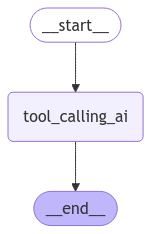

In [138]:
# Since this message update is so common, Langgraph has prebuilt MessagesState
from langgraph.graph import MessagesState # MessagesState and State work equivalently

# Let's build our graph

class MessagesState(MessagesState):
    messages: Annotated[list[AnyMessage], add_messages] # we need to add this line to the class to make it a Pydantic model

# node

def tool_calling_ai(state: MessagesState):
    return {"messages": [ai_with_tool.invoke(state["messages"])]} # invoke the tool_calling_ai tool

# build graph
builder = StateGraph(MessagesState)
builder.add_node('tool_calling_ai', tool_calling_ai)
builder.add_edge(START, 'tool_calling_ai')
builder.add_edge('tool_calling_ai', END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [140]:
message_invoke = graph.invoke({"messages" : HumanMessage(content='Hello!')} )
message_invoke

{'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='dce5fdf9-48dc-4e29-9dfc-da2b4d0d3e08'),
  AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 328, 'total_tokens': 354, 'completion_time': 0.094545455, 'prompt_time': 0.014779952, 'queue_time': 0.233694885, 'total_time': 0.109325407}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_5f849c5a0b', 'finish_reason': 'stop', 'logprobs': None}, id='run-27162e41-c2ba-44c8-bf3d-1f3faf13fc4d-0', usage_metadata={'input_tokens': 328, 'output_tokens': 26, 'total_tokens': 354})]}

In [145]:
message_invoke = graph.invoke({"messages" : HumanMessage(content='You are a calculator assistant with all the tools required to perfom mathematical operations. What is 2 raised to the power of 3')} )
message_invoke

{'messages': [HumanMessage(content='You are a calculator assistant with all the tools required to perfom mathematical operations. What is 2 raised to the power of 3', additional_kwargs={}, response_metadata={}, id='3ba20a56-cf63-4b8d-8956-82f82d69e4c4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_q3tb', 'function': {'arguments': '{"x": 2, "y": 3, "result": 8}', 'name': 'GetExponent'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 353, 'total_tokens': 380, 'completion_time': 0.098181818, 'prompt_time': 0.016811323, 'queue_time': 0.232832494, 'total_time': 0.114993141}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_7b42aeb9fa', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-669cdad9-af27-49f8-9c16-c81649eb0170-0', tool_calls=[{'name': 'GetExponent', 'args': {'x': 2, 'y': 3, 'result': 8}, 'id': 'call_q3tb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 353, 'output_to

In [147]:
message_invoke = graph.invoke({"messages" : HumanMessage(content='Are you still there')} )
message_invoke

{'messages': [HumanMessage(content='Are you still there', additional_kwargs={}, response_metadata={}, id='2704558a-e039-4c60-b678-fbe6bbde2b8b'),
  AIMessage(content="I'm here and ready to help. You can ask me a question or request a function call. If you need to raise a number to a power, I can assist you with the 'GetExponent' function.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 330, 'total_tokens': 375, 'completion_time': 0.163636364, 'prompt_time': 0.01712404, 'queue_time': 0.30162517099999997, 'total_time': 0.180760404}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_7b42aeb9fa', 'finish_reason': 'stop', 'logprobs': None}, id='run-7e932600-4648-4853-b894-9d60177fe7e8-0', usage_metadata={'input_tokens': 330, 'output_tokens': 45, 'total_tokens': 375})]}